# Sedov Blast: FV-DG Hybrid

This notebook describes the "Sedov" blast setup computed with a MUSCLE-DG-Hybrid scheme.

Setup characteristics:

| term                 | symbol    | value               |
|:-------------------- |:---------:|:-------------------:|
| governing equations  |  --       | compressible Euler  |
| equation of state    |  --       |ideal gas (adiabatic)|
| ambient density      | $\rho_0$  | $1.0$               |
| ambient pressure     | $p_0$     | $10^{-5} \approx 0$ |
| adiabatic const.     | $\gamma$  | $1.4$               |
| initial blast energy | $E_0$     | $1.19025916404$     |
| CFD method           |   --      | FV-DG Hybrid        |
| Riemann Flux         |   --      | LLF (Rusanov)       |
| "FV-equiv." resolution | $N_r$   | 512 x 512           |

In [64]:
import sys

sys.path.append('/home/jmark/projects/turbubox/tools/lib')

import interpolate as itpl
import matplotlib.pyplot as plt

import numpy as np
import glob
import h5
import gausslobatto
import ulz
import interpolate
import shellavg
import pandas as pd

%matplotlib inline

dpi = 180//2
figsize = (1.2*780//dpi,1.2*640//dpi)
geo = figsize

resol = 1024 # image resolution

In [65]:
gamma = 1.4
extent = (-0.25,0.25,-0.25,0.25)

def pressure(dens,velx,vely,ener,gamma=1.4):
    return (gamma-1)*(ener - 0.5/dens*(velx**2 + vely**2))

In [66]:
class BlastData:
    def __init__(self, path):
        #fpath = '/mnt/data/couchdg/blast/2d/data/chkpt_0010.h5'
        #self.fpath = list(sorted(glob.glob('/mnt/data/couchdg/blast/2d-muscl/data/chkpt_*.h5')))[-1]
        self.fpath = path
        self.h5file = h5.File(path)

        self.levels = self.get_data('levels')
        self.morton = self.get_data('morton')
                   
        self.states = self.get_data('data/hydro/state')
        
        self.glodof = self.get_data('data/hydro/dof')
        self.persso = self.get_data('data/hydro/persson')
  
        self.moelim = self.get_data('data/hydro/moe')      
      
        if 0:
            self.dilati = self.get_data('data/amr/dilation')
            self.timest = self.get_data('data/hydro/timesteps')
            self.xlimit = self.get_data('data/hydro/xlimit')
            self.ylimit = self.get_data('data/hydro/ylimit')
            self.xdilat = self.get_data('data/hydro/xdilat')
            self.ydilat = self.get_data('data/hydro/ydilat')
            self.accs = self.get_data('data/forcing/accs')

        
        #method = 'nearest'
        method = 'bilinear'

        self.dens = self.stitch([s[:,0,:,:].transpose(0,2,1) for s in self.states],method=method)
        self.momx = self.stitch([s[:,1,:,:].transpose(0,2,1) for s in self.states],method=method)
        self.momy = self.stitch([s[:,2,:,:].transpose(0,2,1) for s in self.states],method=method)
        self.ener = self.stitch([s[:,3,:,:].transpose(0,2,1) for s in self.states],method=method)
        self.pres = pressure(self.dens,self.momx,self.momy,self.ener)
        #self.mach = np.sqrt((momx/dens)**2+(momy/dens)**2) #/np.sqrt(gamma*pres/dens)

        self.pers = self.stitch(self.persso,method='nearest')
        self.moel = self.stitch(self.moelim,method='nearest')
        
        if 0:
            self.accx = stitch([s[:,0,:,:].transpose(0,2,1) for s in accs],trafo=trafo,method=method)
            self.accy = stitch([s[:,1,:,:].transpose(0,2,1) for s in accs],trafo=trafo,method=method)

            self.tstep = stitch([s.value.transpose(0,2,1) for s in timest],trafo=trafo,method=method)
        
    def get_data(self,dname):
        return [self.h5file.get('/ranks/{}/{}'.format(rank,dname)) for rank in self.h5file.get('/ranks').keys()]

    def stitch(self, patches, shape=(resol,resol), trafo=lambda x: x, method='nearest'):
        image = np.zeros(shape)
        for l,m,p in zip(self.levels,self.morton,patches):
            if len(p.shape) > 1: p = trafo(p)
            itpl.cells_to_image(l,m,p,image,method)
        return image

In [67]:
hybrid = [BlastData(p) for p in list(sorted(glob.glob('/mnt/data/couchdg/blast/2d-hybrid-perss/data/chkpt_*.h5')))]
muscl = [BlastData(p) for p in list(sorted(glob.glob('/mnt/data/couchdg/blast/2d-muscl/data/chkpt_*.h5')))]

analytics = [pd.read_table(p, usecols=[1,2,4], names='radius density pressure'.split(), delimiter='\s+') for p in list(sorted(glob.glob('/home/jmark/sedov-*.dat')))]

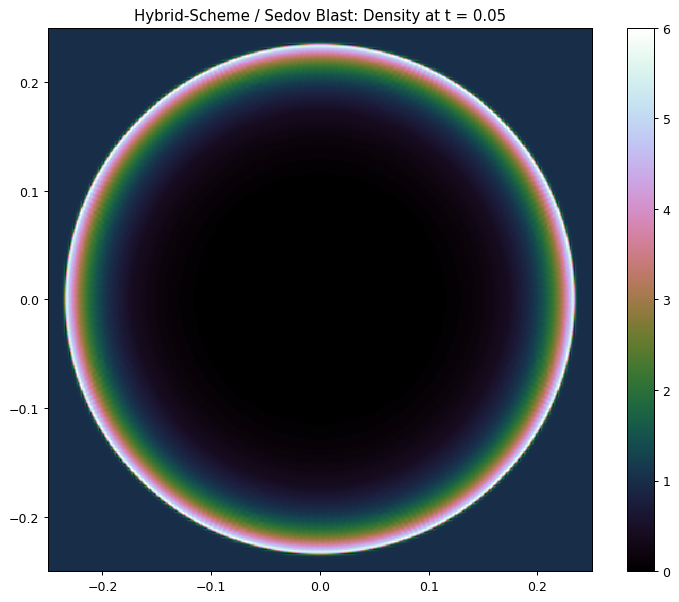

In [68]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('Hybrid-Scheme / Sedov Blast: Density at t = 0.05')

plt.imshow(
    hybrid[-1].dens,
    extent = extent,
    vmin = 0,
    vmax = 6,
    cmap = 'cubehelix',
    origin = 'lower left',  
)
plt.colorbar()

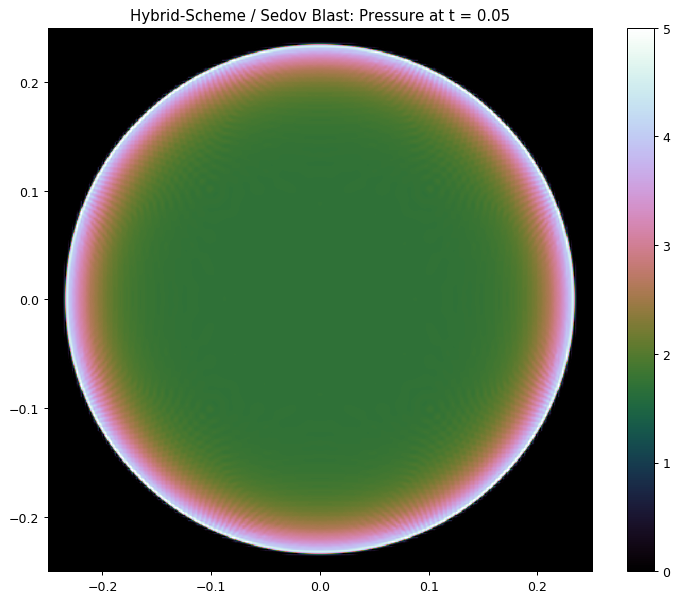

In [69]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('Hybrid-Scheme / Sedov Blast: Pressure at t = 0.05')

plt.imshow(
    hybrid[-1].pres,
    extent = extent,
    vmin = 0,
    vmax = 5,
    cmap = 'cubehelix',
    origin = 'lower left',  
)
plt.colorbar()

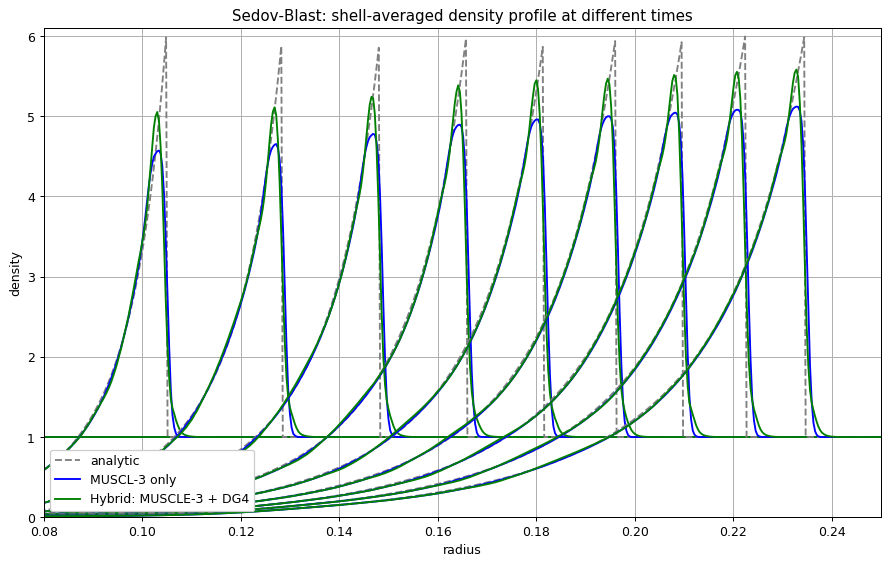

In [70]:
fig = plt.figure(1,figsize=(1.2*geo[0], 0.9*geo[1]), dpi=dpi, frameon=False)
plt.grid()
plt.ylim(0.0,6.1)
plt.xlim(0.08,0.25)

plt.xlabel('radius')
plt.ylabel('density')

plt.title('Sedov-Blast: shell-averaged density profile at different times')

for a, m,h in zip(analytics, muscl, hybrid):    
    plt.plot(a.radius, a.density, label='_nolegend_', ls='--', color='gray')
    
    xs,ys = shellavg.shell_avg_2d(m.dens,nsamples=1024)
    xs = xs/1024/2
    plt.plot(xs,ys, color='blue')

    xs,ys = shellavg.shell_avg_2d(h.dens,nsamples=1024)
    xs = xs/1024/2
    plt.plot(xs,ys, color='green')
    
plt.plot([],[], label='analytic', ls='--',color='gray')
plt.plot([],[], label='MUSCL-3 only', ls='-',color='blue')
plt.plot([],[], label='Hybrid: MUSCLE-3 + DG4', ls='-',color='green')

plt.legend(loc='lower left').get_frame().set_alpha(1)

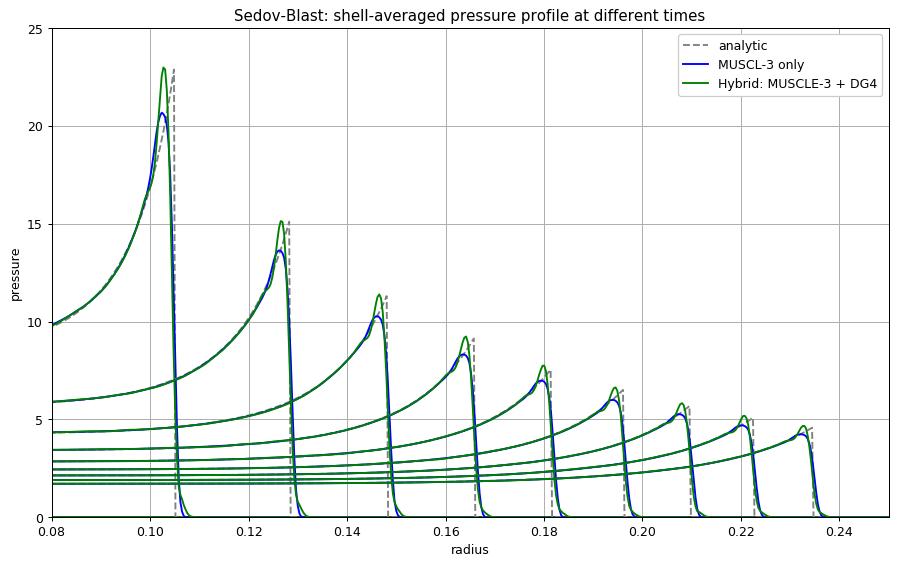

In [71]:
fig = plt.figure(1,figsize=(1.2*geo[0], 0.9*geo[1]), dpi=dpi, frameon=False)
plt.grid()
plt.ylim(0.0,25)
plt.xlim(0.08,0.25)

plt.xlabel('radius')
plt.ylabel('pressure')

plt.title('Sedov-Blast: shell-averaged pressure profile at different times')

for a, m,h in zip(analytics, muscl, hybrid):    
    plt.plot(a.radius, a.pressure, label='_nolegend_', ls='--', color='gray')
    
    xs,ys = shellavg.shell_avg_2d(m.pres,nsamples=1024)
    xs = xs/1024/2
    plt.plot(xs,ys, color='blue')

    xs,ys = shellavg.shell_avg_2d(h.pres,nsamples=1024)
    xs = xs/1024/2
    plt.plot(xs,ys, color='green')
    
plt.plot([],[], label='analytic', ls='--',color='gray')
plt.plot([],[], label='MUSCL-3 only', ls='-',color='blue')
plt.plot([],[], label='Hybrid: MUSCLE-3 + DG4', ls='-',color='green')

plt.legend(loc='upper right').get_frame().set_alpha(1)

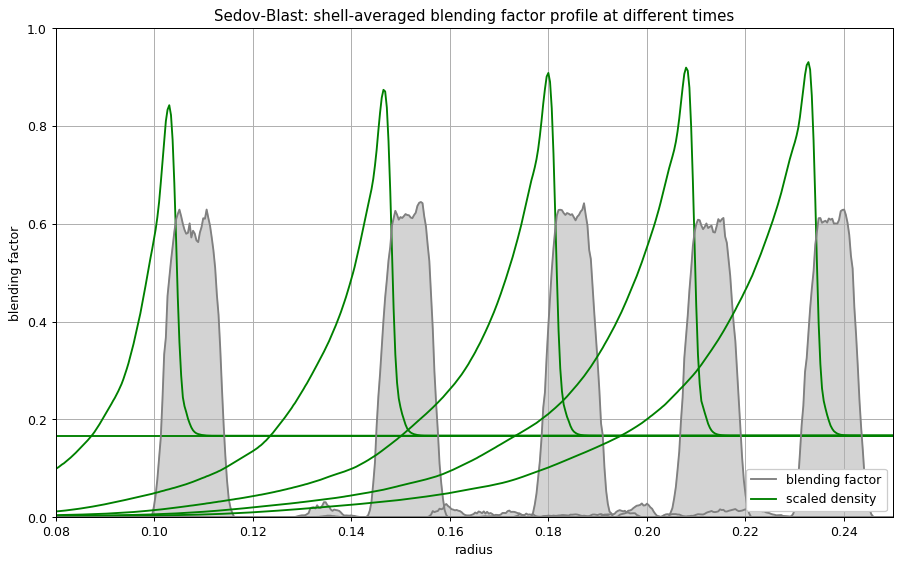

In [75]:
fig = plt.figure(1,figsize=(1.2*geo[0], 0.9*geo[1]), dpi=dpi, frameon=False)
plt.grid()
plt.ylim(0.0,1.0)
plt.xlim(0.08,0.25)

plt.xlabel('radius')
plt.ylabel('blending factor')

plt.title('Sedov-Blast: shell-averaged blending factor profile at different times')

i = 0

for a, m,h in zip(analytics, muscl, hybrid):
    i += 1
    #print(i % 2)
    if (i % 2) == 0: continue
    
    xs,ys = shellavg.shell_avg_2d(h.dens,nsamples=1024)
    xs = xs/1024/2
    plt.plot(xs,ys/6, color='green')
        
    xs,ys = shellavg.shell_avg_2d(np.where(h.pers > 1-h.moel, h.pers,1-h.moel),nsamples=1024)
    xs = xs/1024/2
    plt.fill(xs,ys, color='lightgray')
    plt.plot(xs,ys, color='gray')
    
plt.plot([],[], label='blending factor', ls='-',color='gray')
plt.plot([],[], label='scaled density', ls='-',color='green')

plt.legend(loc='lower right').get_frame().set_alpha(1)

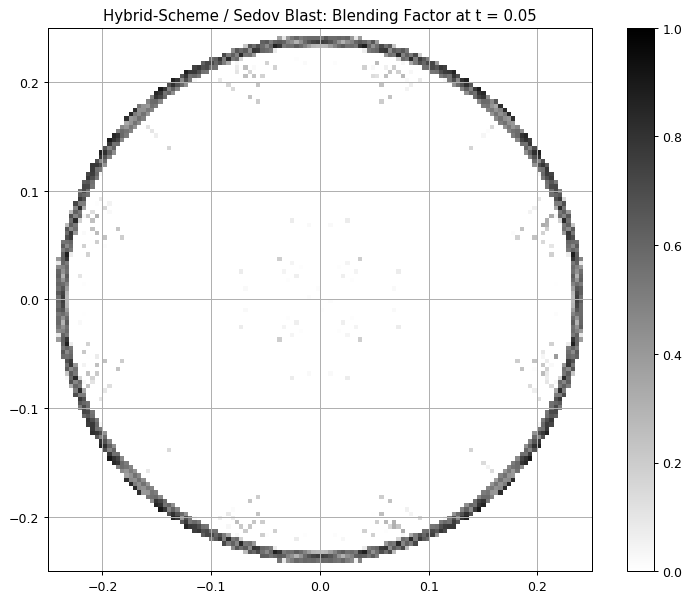

In [73]:
fig = plt.figure(figsize=figsize,dpi=dpi)

plt.title('Hybrid-Scheme / Sedov Blast: Blending Factor at t = 0.05')

h = hybrid[-1]

plt.grid()
plt.imshow(
    np.where(h.pers > 1-h.moel, h.pers,1-h.moel),
    extent = extent,
    vmin = 0,
    vmax = 1,
    cmap = 'gray_r',
    origin = 'lower left',  
)
plt.colorbar()